In [2]:
!pip install iterative-stratification albumentations timm

In [3]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import tensorflow as tf
from fastai.vision.all import *
from fastai.callback.all import *
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import gc
import albumentations
from albumentations.pytorch import ToTensorV2
import warnings
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import timm
import shutil
from sklearn.utils.class_weight import compute_class_weight

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
config = {
    'seed': 3407,
    'use_cuda': True,
    'image_size': 224,
    'batch_size': 64,
    'num_workers': 4,
    'num_folds': 5,
    'model_name': 'timm/resnet50.a1_in1k',
    'mixed_precision' : True,
    'augmentation_type': None,  # or 'cutmix','cutout',None
#     'fine_tune_epochs': 5,
    'fit_one_cycle_epochs': 10,
    'learning_rate': 1e-4,
    'train_csv_path': '/kaggle/working/train_data.csv',
    'test_csv_path': '/kaggle/working/test_data.csv',
    'train_image_path' : '/kaggle/input/pest-data',
    'test_image_path' : '/kaggle/input/pest-data',
    'output_csv_path': None,
    'output_csv_confidence_path': None, # For Pesudo Label
    'num_gpus': torch.cuda.device_count()  # Use all available GPUs
}

In [6]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

random_seed(config['seed'], config['use_cuda'])

In [4]:
from sklearn.model_selection import train_test_split

image_paths = []
labels = []

dataset = '/kaggle/input/pest-data'

for folder_name in os.listdir(dataset):
    folder_path = os.path.join(dataset, folder_name)

    if os.path.isdir(folder_path):
        images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for image_name in images:
            image_path = os.path.join(folder_path, image_name)
            image_paths.append(image_path)
            labels.append(folder_name)

data = {
    'image_path': image_paths,
    'label': labels
}
df = pd.DataFrame(data)

# Split the data into training and testing sets (80% train, 20% test)
train_daf, test_daf = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# File paths to save the CSV files
train_csv_file_path = '/kaggle/working/train_data.csv'
test_csv_file_path = '/kaggle/working/test_data.csv'

# Save the training and testing DataFrames to separate CSV files
train_daf.to_csv(train_csv_file_path, index=False)
test_daf.to_csv(test_csv_file_path, index=False)

print(f'Training DataFrame saved to {train_csv_file_path}')
print(f'Test DataFrame saved to {test_csv_file_path}')


Training DataFrame saved to /kaggle/working/train_data.csv
Test DataFrame saved to /kaggle/working/test_data.csv


In [7]:
train_df = pd.read_csv(config['train_csv_path'])
train_df['image_path'] = train_df['image_path'].apply(lambda x : x)
train_df

,image_path,label
0,/kaggle/input/pest-data/earthworms/earthworms (104).jpg,earthworms
1,/kaggle/input/pest-data/moth/moth (258).jpg,moth
2,/kaggle/input/pest-data/wasp/wasp (755).jpg,wasp
3,/kaggle/input/pest-data/earthworms/earthworms (212).jpg,earthworms
4,/kaggle/input/pest-data/ants/ants (265).jpg,ants
...,...,...
4390,/kaggle/input/pest-data/beetle/beetle (207).jpg,beetle
4391,/kaggle/input/pest-data/snail/snail (470).jpg,snail
4392,/kaggle/input/pest-data/wasp/wasp (991).jpg,wasp
4393,/kaggle/input/pest-data/beetle/beetle (16).jpg,beetle


<Axes: xlabel='label'>

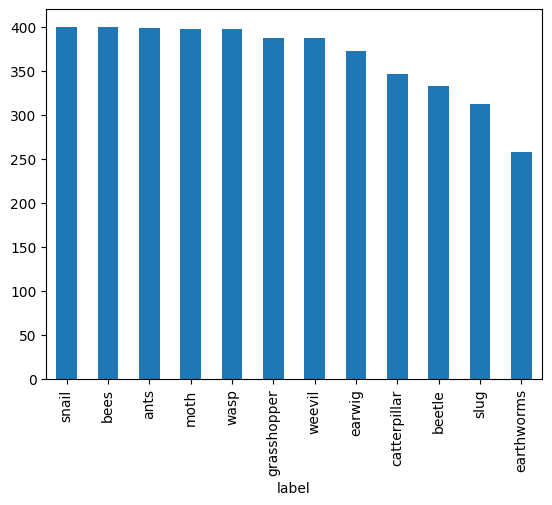

In [8]:
train_df.label.value_counts().plot.bar()

In [9]:
strat_kfold = MultilabelStratifiedKFold(n_splits=config['num_folds'], random_state=config['seed'], shuffle=True)
train_df['fold'] = -1
for i, (_, test_index) in enumerate(strat_kfold.split(train_df.image_path.values, train_df.iloc[:,1:].values)):
    train_df.iloc[test_index, -1] = i
    
train_df.head()

,image_path,label,fold
0,/kaggle/input/pest-data/earthworms/earthworms (104).jpg,earthworms,4
1,/kaggle/input/pest-data/moth/moth (258).jpg,moth,0
2,/kaggle/input/pest-data/wasp/wasp (755).jpg,wasp,4
3,/kaggle/input/pest-data/earthworms/earthworms (212).jpg,earthworms,0
4,/kaggle/input/pest-data/ants/ants (265).jpg,ants,2


<Axes: xlabel='fold'>

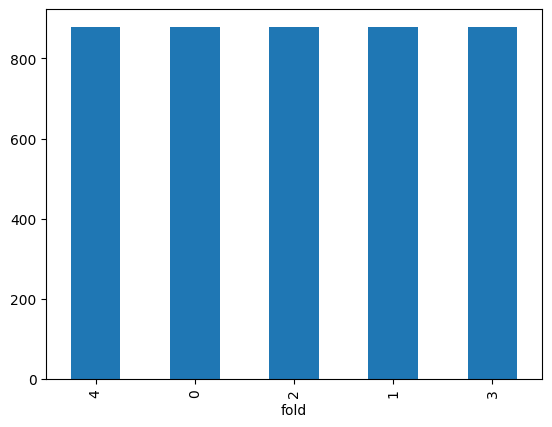

In [10]:
train_df.fold.value_counts().plot.bar()

In [11]:
class_labels = train_df['label'].values
classes = np.unique(class_labels)
class_weights = compute_class_weight('balanced', classes=classes, y=class_labels)
class_weights_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

# Define custom loss function with class weights
def weighted_loss(pred, target):
    weights_tensor = torch.tensor([class_weights_dict[cls] for cls in dls.vocab]).float().to('cuda')
    return F.cross_entropy(pred, target, weight=weights_tensor)

# Data Augmentation

In [12]:
class AlbumentationsTransform(RandTransform):
    split_idx, order = None, 2
    def __init__(self, train_aug, valid_aug): 
        super().__init__()
        store_attr()

    def before_call(self, b, split_idx):
        self.idx = split_idx

    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
            
        aug_img = aug_img.astype(np.uint8)
        return PILImage.create(aug_img)

In [13]:
warnings.filterwarnings('ignore')

size = config['image_size']
def get_train_aug(): return albumentations.Compose([
            albumentations.Resize(always_apply=False, p=1.0, height=size, width=size, interpolation=0),
            #AutoContrast(),
            #albumentations.PadIfNeeded(always_apply=False, p=1.0, min_height=size, min_width=size, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=(255, 255, 255), mask_value=None), #Extra tip, use size that's suitable for the efficentNetwork you are using.
            albumentations.Rotate(limit=(-20, 20)),
#             albumentations.HorizontalFlip(p=0.5),
#             albumentations.VerticalFlip(p=0.5),
            #albumentations.Sharpen(always_apply=False, p=1.0, alpha=(0.2, 0.5), lightness=(0.5, 1.0)),
            #albumentations.GaussianBlur(always_apply=False, p=1.0, blur_limit=(3, 7), sigma_limit=(0.0, 0)),
            # #albumentations.ShiftScaleRotate(always_apply=False, p=1.0, shift_limit_x=(-0.06, 0.06), shift_limit_y=(-0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-20, 20), interpolation=0, border_mode=0, value=(255, 255, 255), mask_value=None, rotate_method='largest_box'),
            # albumentations.HueSaturationValue(
            #     hue_shift_limit=0.2, 
            #     sat_shift_limit=0.2, 
            #     val_shift_limit=0.2, 
            #     p=0.5
            # ),
            # #albumentations.ColorJitter(contrast=(0.9, 1.1)),
            # #albumentations.CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4), tile_grid_size=(8, 8)),
            # albumentations.RandomBrightnessContrast(
            #     brightness_limit=(-0.2,0.2), 
            #     contrast_limit=(-0.2, 0.2), 
            #     p=0.5
            # ),
            #albumentations.RandomGamma(),
            #albumentations.ToGray(always_apply=False, p=1.0)
            
           #albumentations.RandomGridShuffle(p=0.5)\
    ], p=1.0)



def get_valid_aug(): return albumentations.Compose([
            albumentations.Resize(always_apply=False, p=1.0, height=size, width=size, interpolation=0),
  
            #albumentations.PadIfNeeded(always_apply=False, p=1.0, min_height=size, min_width=size, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=(255, 255, 255), mask_value=None),
            #albumentations.ToGray(always_apply=False, p=1.0),
            #AutoContrast(),
             
            ], p=1.0)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

In [14]:
def get_data(fold=0):
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader(0),
        get_y=ColReader(1),
        splitter=IndexSplitter(train_df[train_df.fold == fold].index),
        item_tfms=[AlbumentationsTransform(get_train_aug(), get_train_aug())],
        batch_tfms=[Normalize.from_stats(*imagenet_stats)]
    ).dataloaders(train_df, bs=config['batch_size'], num_workers=config['num_workers'])

In [15]:
test_df = pd.read_csv(config['test_csv_path'])
test_df['image_path'] = test_df['image_path'].apply(lambda x : x )
tstpng = test_df.copy()
tstpng.head()

,image_path,label
0,/kaggle/input/pest-data/beetle/beetle (350).jpg,beetle
1,/kaggle/input/pest-data/ants/ants (203).jpg,ants
2,/kaggle/input/pest-data/snail/snail (463).jpg,snail
3,/kaggle/input/pest-data/snail/snail (330).jpg,snail
4,/kaggle/input/pest-data/catterpillar/catterpillar (345).jpg,catterpillar


In [16]:
def create_model(model_name, num_classes):
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    if config['num_gpus'] > 1:
        model = nn.DataParallel(model)
    return model

In [18]:
def get_augmentation_callback(augmentation_type, alpha=1.0, cutout_size=8):
    if augmentation_type == 'mixup':
        return MixUp(alpha=alpha)
    elif augmentation_type == 'cutmix':
        return CutMix(alpha=alpha)
    elif augmentation_type == 'cutout':
        # Return a callback that applies CutOut
        return aug_transforms(cutout=cutout_size)
    else:
        return None

In [19]:
all_preds = []

for i in range(config['num_folds']):
    dls = get_data(i)

    model = create_model(config['model_name'], num_classes=len(dls.vocab))
    augmentation_callback = get_augmentation_callback(config['augmentation_type'])
    learn = Learner(dls, model,
                    loss_func=weighted_loss,  # Use the custom loss function
                    metrics=accuracy,
                    cbs=[SaveModelCallback(monitor='valid_loss')])

    if config['mixed_precision']:
        learn = learn.to_fp16()

    # Move model to GPU(s)
    learn.model = learn.model.to('cuda')

    # Clear cache before training
    torch.cuda.empty_cache()
    
#     learn.fine_tune(config['fine_tune_epochs'])
    learn.fit_one_cycle(config['fit_one_cycle_epochs'], lr_max=config['learning_rate'], cbs=[EarlyStoppingCallback(monitor='valid_loss')])
#     learn.fit_one_cycle(config['fit_one_cycle_epochs'])
    learn.dls = get_data(i)
#     learn.fine_tune(config['fit_one_cycle_epochs'], cbs=EarlyStoppingCallback(monitor='valid_loss'))
    
    # Clear cache after training
    torch.cuda.empty_cache()

    tst_dl = learn.dls.test_dl(tstpng)
    preds, _ = learn.get_preds(dl=tst_dl)
    all_preds.append(preds)
    del learn
    torch.cuda.empty_cache()
    gc.collect()
    
print('Training Completed')

epoch,train_loss,valid_loss,accuracy,time
0,2.460162,2.449431,0.192264,00:21
1,2.410974,2.323731,0.559727,00:19
2,2.219712,1.859044,0.766780,00:18
3,1.731835,1.047233,0.869170,00:19
4,1.203533,0.682731,0.899886,00:18
5,0.846852,0.502945,0.910125,00:18
6,0.628239,0.437436,0.915813,00:18
7,0.515633,0.404037,0.911263,00:16
8,0.451136,0.379618,0.924915,00:16
9,0.427032,0.392584,0.919226,00:15


Better model found at epoch 0 with valid_loss value: 2.4494307041168213.
Better model found at epoch 1 with valid_loss value: 2.3237311840057373.
Better model found at epoch 2 with valid_loss value: 1.8590443134307861.
Better model found at epoch 3 with valid_loss value: 1.047232985496521.
Better model found at epoch 4 with valid_loss value: 0.6827311515808105.
Better model found at epoch 5 with valid_loss value: 0.5029449462890625.
Better model found at epoch 6 with valid_loss value: 0.4374362528324127.
Better model found at epoch 7 with valid_loss value: 0.4040367603302002.
Better model found at epoch 8 with valid_loss value: 0.37961795926094055.
No improvement since epoch 8: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,2.479196,2.469229,0.137656,00:16
1,2.433470,2.371324,0.463026,00:16
2,2.253973,1.985993,0.713311,00:16
3,1.779722,1.163034,0.831627,00:16
4,1.223577,0.753488,0.874858,00:15
5,0.841442,0.579262,0.886234,00:16
6,0.622099,0.504453,0.886234,00:16
7,0.501449,0.469728,0.901024,00:16
8,0.438717,0.463602,0.901024,00:15
9,0.415555,0.446196,0.898749,00:15


Better model found at epoch 0 with valid_loss value: 2.4692294597625732.
Better model found at epoch 1 with valid_loss value: 2.371324300765991.
Better model found at epoch 2 with valid_loss value: 1.9859925508499146.
Better model found at epoch 3 with valid_loss value: 1.1630337238311768.
Better model found at epoch 4 with valid_loss value: 0.7534882426261902.
Better model found at epoch 5 with valid_loss value: 0.579261839389801.
Better model found at epoch 6 with valid_loss value: 0.5044525265693665.
Better model found at epoch 7 with valid_loss value: 0.4697283208370209.
Better model found at epoch 8 with valid_loss value: 0.4636021554470062.
Better model found at epoch 9 with valid_loss value: 0.44619646668434143.


epoch,train_loss,valid_loss,accuracy,time
0,2.472315,2.461298,0.168373,00:15
1,2.426783,2.359955,0.499431,00:16
2,2.258530,1.984063,0.716724,00:15
3,1.807941,1.165426,0.827076,00:16
4,1.243367,0.737476,0.868032,00:16
5,0.854747,0.600021,0.882821,00:18
6,0.629867,0.510250,0.894198,00:18
7,0.503855,0.476214,0.898749,00:18
8,0.448407,0.483911,0.889647,00:18


Better model found at epoch 0 with valid_loss value: 2.4612979888916016.
Better model found at epoch 1 with valid_loss value: 2.359954595565796.
Better model found at epoch 2 with valid_loss value: 1.9840633869171143.
Better model found at epoch 3 with valid_loss value: 1.1654257774353027.
Better model found at epoch 4 with valid_loss value: 0.7374759316444397.
Better model found at epoch 5 with valid_loss value: 0.6000209450721741.
Better model found at epoch 6 with valid_loss value: 0.5102499127388.
Better model found at epoch 7 with valid_loss value: 0.47621384263038635.
No improvement since epoch 7: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,2.483396,2.472285,0.120592,00:18
1,2.439961,2.376130,0.427759,00:18
2,2.274287,2.015873,0.713311,00:18
3,1.810537,1.190384,0.807736,00:18
4,1.251167,0.737583,0.858931,00:18
5,0.862710,0.581494,0.880546,00:18
6,0.651501,0.508344,0.901024,00:18
7,0.528387,0.481012,0.896473,00:19
8,0.465342,0.471912,0.891923,00:18
9,0.437324,0.470948,0.896473,00:18


Better model found at epoch 0 with valid_loss value: 2.4722847938537598.
Better model found at epoch 1 with valid_loss value: 2.3761298656463623.
Better model found at epoch 2 with valid_loss value: 2.0158731937408447.
Better model found at epoch 3 with valid_loss value: 1.1903841495513916.
Better model found at epoch 4 with valid_loss value: 0.7375832796096802.
Better model found at epoch 5 with valid_loss value: 0.5814935564994812.
Better model found at epoch 6 with valid_loss value: 0.5083444118499756.
Better model found at epoch 7 with valid_loss value: 0.48101210594177246.
Better model found at epoch 8 with valid_loss value: 0.47191157937049866.
Better model found at epoch 9 with valid_loss value: 0.47094815969467163.


epoch,train_loss,valid_loss,accuracy,time
0,2.485627,2.474838,0.108077,00:18
1,2.443073,2.385113,0.445961,00:18
2,2.285138,2.011964,0.697383,00:18
3,1.833517,1.148028,0.824801,00:18
4,1.266870,0.742033,0.874858,00:18
5,0.875928,0.575475,0.878271,00:18
6,0.644898,0.512978,0.879408,00:17
7,0.519686,0.469447,0.893060,00:16
8,0.466483,0.465969,0.890785,00:15
9,0.445975,0.454750,0.889647,00:16


Better model found at epoch 0 with valid_loss value: 2.4748380184173584.
Better model found at epoch 1 with valid_loss value: 2.385113000869751.
Better model found at epoch 2 with valid_loss value: 2.0119636058807373.
Better model found at epoch 3 with valid_loss value: 1.1480276584625244.
Better model found at epoch 4 with valid_loss value: 0.7420325875282288.
Better model found at epoch 5 with valid_loss value: 0.5754748582839966.
Better model found at epoch 6 with valid_loss value: 0.5129778385162354.
Better model found at epoch 7 with valid_loss value: 0.4694473147392273.
Better model found at epoch 8 with valid_loss value: 0.4659692347049713.
Better model found at epoch 9 with valid_loss value: 0.45475029945373535.


Training Completed


**Prediction and Submission**

In [20]:
sub = pd.read_csv(config['test_csv_path'])
preds = np.mean(np.stack(all_preds), axis=0)
preds = torch.from_numpy(preds)
preds

tensor([[-1.0835, -2.2750,  0.8075,  ..., -1.7025, -1.8865,  3.6594],
        [ 4.5461, -2.3840,  0.0846,  ..., -2.3645, -2.1318, -1.7002],
        [-2.2305, -1.9439, -0.8782,  ...,  3.2107, -2.2828, -1.7793],
        ...,
        [-0.4097, -2.0125,  0.6534,  ..., -3.2527, -0.2584, -1.8824],
        [-2.6660, -3.5273, -1.9158,  ..., -2.8074, -3.5957, -4.4488],
        [-2.6469, -2.0531, -0.3998,  ..., -2.4232, -1.8539, -2.5758]])

In [21]:
idxs = preds.argmax(dim=1)
confidences, _ = torch.max(preds, dim=1)
vocab = np.array(dls.vocab)

sub['predict'] = vocab[idxs]
sub

,image_path,label,predict
0,/kaggle/input/pest-data/beetle/beetle (350).jpg,beetle,weevil
1,/kaggle/input/pest-data/ants/ants (203).jpg,ants,ants
2,/kaggle/input/pest-data/snail/snail (463).jpg,snail,snail
3,/kaggle/input/pest-data/snail/snail (330).jpg,snail,snail
4,/kaggle/input/pest-data/catterpillar/catterpillar (345).jpg,catterpillar,catterpillar
...,...,...,...
1094,/kaggle/input/pest-data/grasshopper/grasshopper (201).jpg,grasshopper,grasshopper
1095,/kaggle/input/pest-data/beetle/beetle (164).jpg,beetle,beetle
1096,/kaggle/input/pest-data/grasshopper/grasshopper (40).jpg,grasshopper,beetle
1097,/kaggle/input/pest-data/earthworms/earthworms (71).jpg,earthworms,earthworms


Total predictions: 1099
Correct predictions: 996
Accuracy: 90.63%

Classification Report:
              precision    recall  f1-score   support

        ants       0.97      0.97      0.97       100
        bees       0.95      0.98      0.97       100
      beetle       0.86      0.82      0.84        83
catterpillar       0.67      0.89      0.76        87
  earthworms       0.83      0.80      0.81        65
      earwig       0.88      0.80      0.84        93
 grasshopper       0.95      0.84      0.89        97
        moth       0.96      0.98      0.97        99
        slug       0.88      0.77      0.82        78
       snail       0.98      0.99      0.99       100
        wasp       0.97      0.98      0.98       100
      weevil       0.96      0.98      0.97        97

    accuracy                           0.91      1099
   macro avg       0.91      0.90      0.90      1099
weighted avg       0.91      0.91      0.91      1099



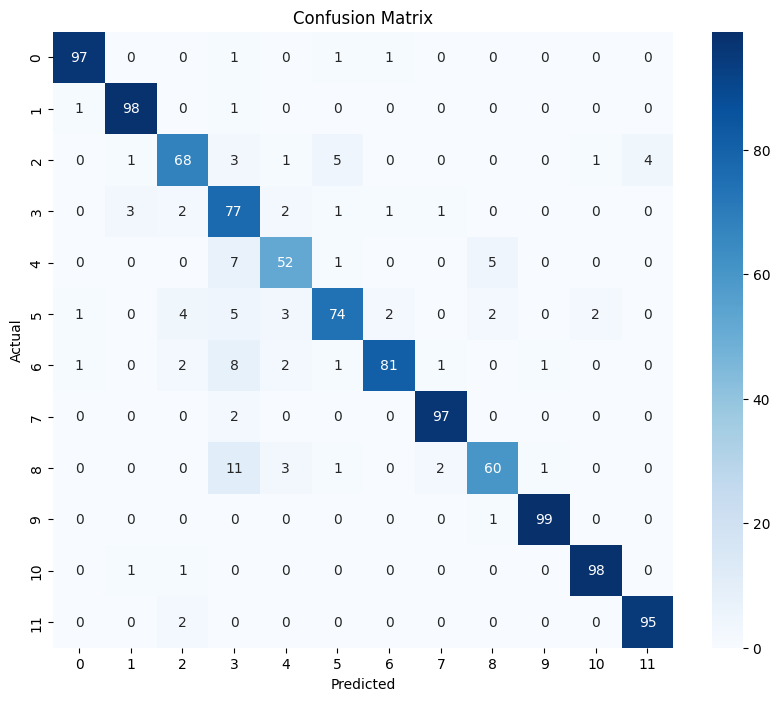

In [22]:
# Calculate total number of predictions
total_predictions = len(sub)

# Calculate number of correct predictions
correct_predictions = (sub['label'] == sub['predict']).sum()

# Calculate accuracy
accuracy = correct_predictions / total_predictions

# Generate a classification report
from sklearn.metrics import classification_report
report = classification_report(sub['label'], sub['predict'])

# Print results
print(f"Total predictions: {total_predictions}")
print(f"Correct predictions: {correct_predictions}")
print(f"Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(report)

# Optional: Generate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(sub['label'], sub['predict'])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [27]:
import torch
from torchvision import transforms
import time
def create_model(num_classes):
    model = models.resnet50(pretrained=True)
    
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def predict(image_path, model_path, class_names):
    model = create_model(num_classes=len(class_names))
    
    state_dict = torch.load(model_path)
    
    new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    
    model.load_state_dict(new_state_dict, strict=False)
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize(256),  
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)
    start_time = time.time()
    
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_class_index = probabilities.argmax().item()
        predicted_class = class_names[predicted_class_index]
    end_time = time.time()
    inference_time = end_time - start_time 
    print(f"Inference time: {inference_time:.6f} seconds")  
    return predicted_class, probabilities[0].tolist()

    
def display_probabilities(class_names, probabilities):
    # Sort probabilities in descending order
    sorted_probs = sorted(zip(class_names, probabilities), key=lambda x: x[1], reverse=True)
    
    print("Class Probabilities:")
    print("-------------------")
    for class_name, prob in sorted_probs:
        print(f"{class_name:<15} : {prob:.4f} ({prob*100:.2f}%)")

In [28]:
image_path = '/kaggle/input/test-data/wild-bee-banner.jpg'
model_path = '/kaggle/working/models/model.pth'
class_names = ['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

predicted_class, probabilities = predict(image_path, model_path, class_names)
print(f"Predicted class: {predicted_class}")
print()
display_probabilities(class_names, probabilities)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s] 


Inference time: 0.244082 seconds
Predicted class: bees

Class Probabilities:
-------------------
bees            : 0.9359 (93.59%)
wasp            : 0.0355 (3.55%)
catterpillar    : 0.0089 (0.89%)
beetle          : 0.0048 (0.48%)
earwig          : 0.0040 (0.40%)
grasshopper     : 0.0033 (0.33%)
ants            : 0.0019 (0.19%)
slug            : 0.0018 (0.18%)
earthworms      : 0.0014 (0.14%)
weevil          : 0.0012 (0.12%)
snail           : 0.0008 (0.08%)
moth            : 0.0005 (0.05%)
